In [1]:
def plot_spatio_temporal_data_cluster(spatio_temporal_data, categorical_data, num_points=10, method='random_sampling', cluster_name=None):
    """
    Plot spatio-temporal data based on categorical values.
    
    Parameters:
        spatio_temporal_data (xarray.DataArray): The spatio-temporal data to be plotted.
        categorical_data (xarray.DataArray): The categorical data with cluster values.
        num_points (int): The number of random points to sample from each category, the default is 10 (if method='random').
        method (str): Method of selecting points. Options are 'random_sampling' or 'summary'.
    """
    # Initialize dictionary to store sampled points for each category
    samples = {}
    time = spatio_temporal_data.time.to_numpy()
    
    categories = np.unique(categorical_data.values[~np.isnan(categorical_data.values)])
    
    for category in categories:
        # Get the indices for the current category
        category_mask = categorical_data == category
        category_points = np.argwhere(category_mask.values)  # Get the indices where the category matches

        if method == 'random_sampling':
            # Randomly select points from the available ones
            if len(category_points) > num_points:
                selected_indices = np.random.choice(len(category_points), size=num_points, replace=False)
            else:
                selected_indices = np.arange(len(category_points))  # If less than num_points available, take all

            selected_points = category_points[selected_indices]

            # Extract the time series data for the selected points
            category_sample = []
            for point in selected_points:
                x_idx, y_idx = point[0], point[1]
                category_sample.append(spatio_temporal_data[:, x_idx, y_idx].values)  # Extract time series for the point

            samples[category] = np.array(category_sample)
        
        elif method == 'summary':
            # Use the category mask to directly extract the spatio-temporal data points for the current category
            masked_data = spatio_temporal_data.where(category_mask, drop=True)  # This will give you the data with NaNs where mask is False
            
            # Reshape data to ensure (n_points, time) where n_points = x * y
            all_points = masked_data.stack(points=('lon', 'lat')).values  # Stack spatial dimensions into one dimension
        
            # Filter out rows where all time steps are NaN, keeping points with at least some valid data
            valid_points_mask = ~np.isnan(all_points).all(axis=0)  # Find columns where there is valid data
            all_points = all_points[:, valid_points_mask]
        
            if all_points.shape[1] == 0:
                raise ValueError("No valid points found in the selected category.")
        
            # Calculate quantiles and other statistics using numpy's built-in functions
            quantiles = {
                '10th': np.percentile(all_points, 10, axis=1),
                '90th': np.percentile(all_points, 90, axis=1),
                'min': np.nanmin(all_points, axis=1),
                'max': np.nanmax(all_points, axis=1),
                'median': np.nanmedian(all_points, axis=1)
            }
        
            samples[category] = quantiles

    # Create a figure with subplots (1 row per category)
    num_categories = len(samples.keys())
    if num_categories == 0:
        raise ValueError("No valid categories found in the data to plot.")
    
    fig, axs = plt.subplots(num_categories, 1, figsize=(25, 20), sharex=True)

    # If there's only one category, axs is not a list, so we need to handle it
    if num_categories == 1:
        axs = [axs]

    for i, (category, category_samples) in enumerate(samples.items()):
        ax = axs[i]

        if method == 'random_sampling':
            for sample in category_samples:
                ax.plot(time, sample)

            ax.set_ylabel('Data Value')
            ax.set_title(f'{cluster_name if cluster_name else "Cluster"}: {category}')
        
        elif method == 'summary':
            ax.plot(time, category_samples['10th'], label='10th Percentile', color='blue', linestyle='--')
            ax.plot(time, category_samples['90th'], label='90th Percentile', color='red', linestyle='--')
            ax.plot(time, category_samples['median'], label='Median', color='green')
            ax.fill_between(time, category_samples['min'], category_samples['max'], color='gray', alpha=0.2, label='Min-Max Range')

            ax.set_ylabel('Data Value')
            ax.set_title(f'{cluster_name if cluster_name else "Cluster"}: {category}')
            ax.legend(loc='upper right')

    # Set common x-label for all subplots
    plt.xlabel('Time')
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()
    
    return fig, axs

In [2]:
import xarray as xr
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from hython.utils import write_to_zarr, read_from_zarr, set_seed

SURROGATE_INPUT = "https://eurac-eo.s3.amazonaws.com/INTERTWIN/SURROGATE_INPUT/adg1km_eobs_original.zarr/"
train_temporal_range = slice("2012-01-01","2022-12-31")

target_names = ["vwc"]

Y = (
    read_from_zarr(url=SURROGATE_INPUT , group="y")
    .sel(time=train_temporal_range)[target_names]
)

Xs = read_from_zarr(url=SURROGATE_INPUT , group="xs")["wflow_landuse"]

dataset = Y.vwc

# Create a new dataset where to assign categorical values
categorized_data = xr.where((Xs >= 100) & (Xs < 200), 1, 
                   xr.where((Xs >= 200) & (Xs < 300), 2, 
                   xr.where((Xs >= 300) & (Xs < 400), 3, 
                   xr.where((Xs >= 400) & (Xs < 500), 4, 
                   xr.where((Xs >= 500) & (Xs < 600), 5, np.nan)))))


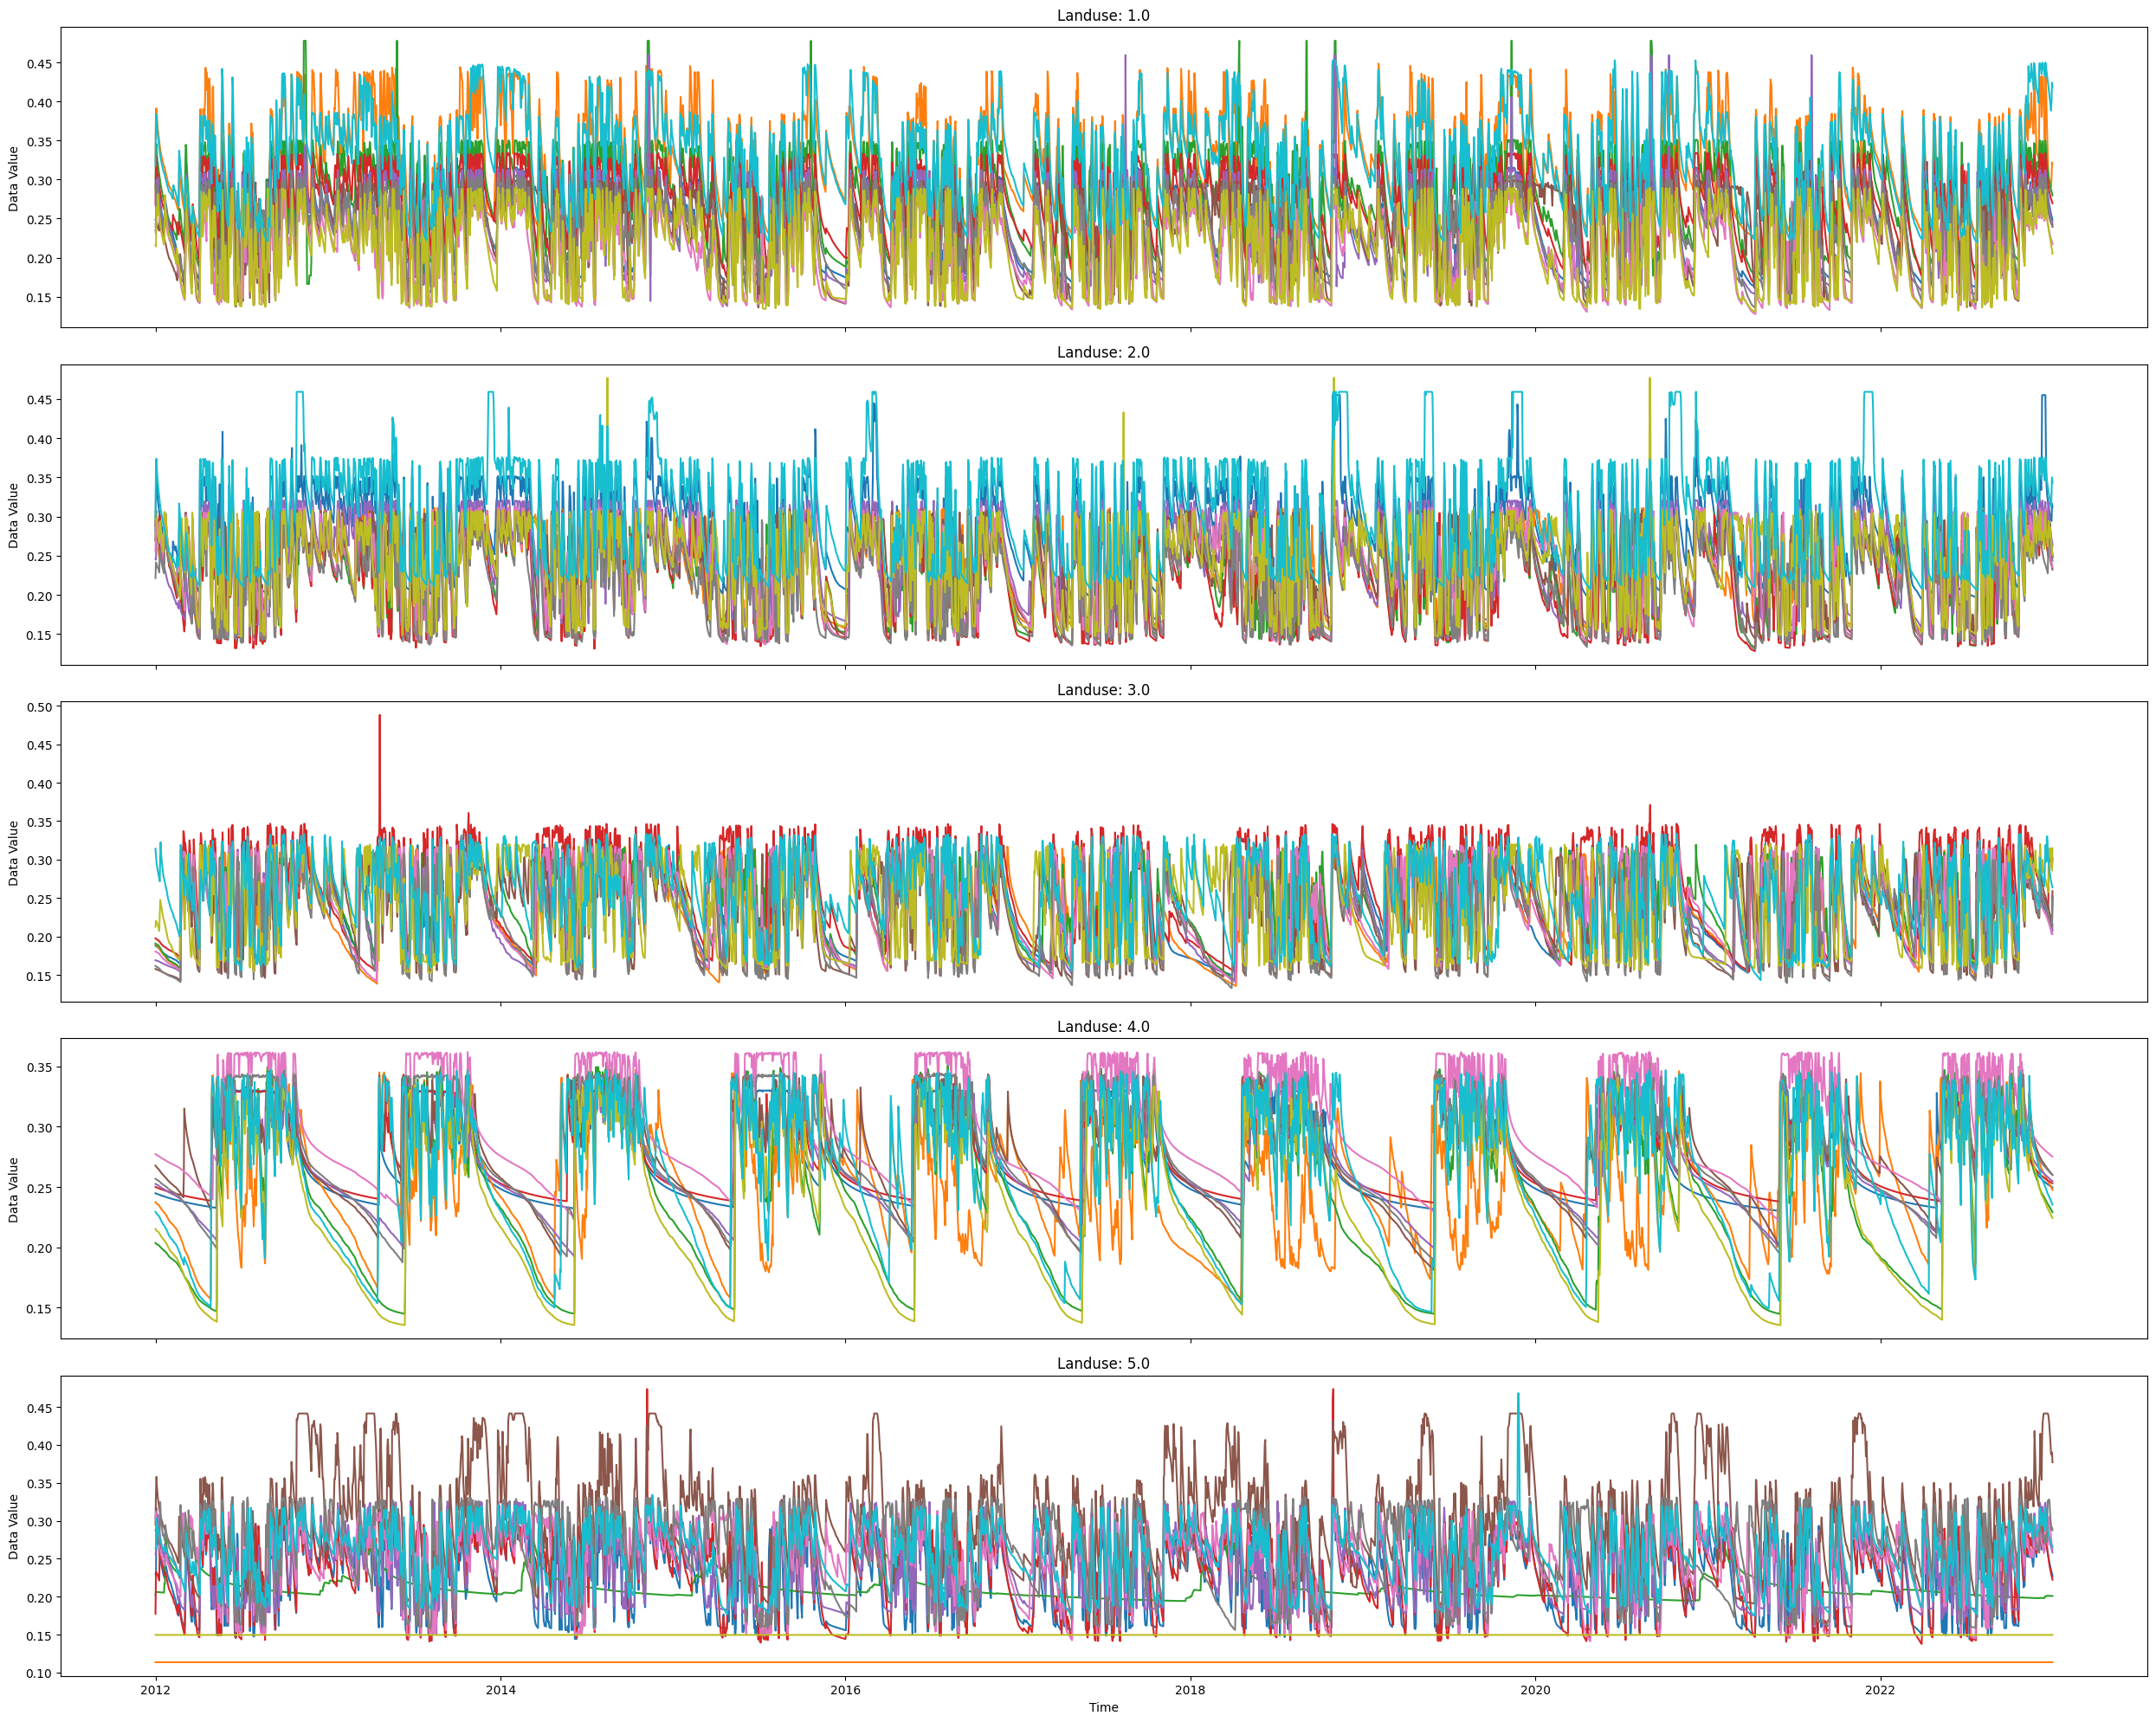

CPU times: user 38 s, sys: 26 s, total: 1min 4s
Wall time: 3min 7s


In [3]:
%time figure, axss = plot_spatio_temporal_data_cluster(dataset, categorized_data, method="random_sampling", cluster_name="Landuse")

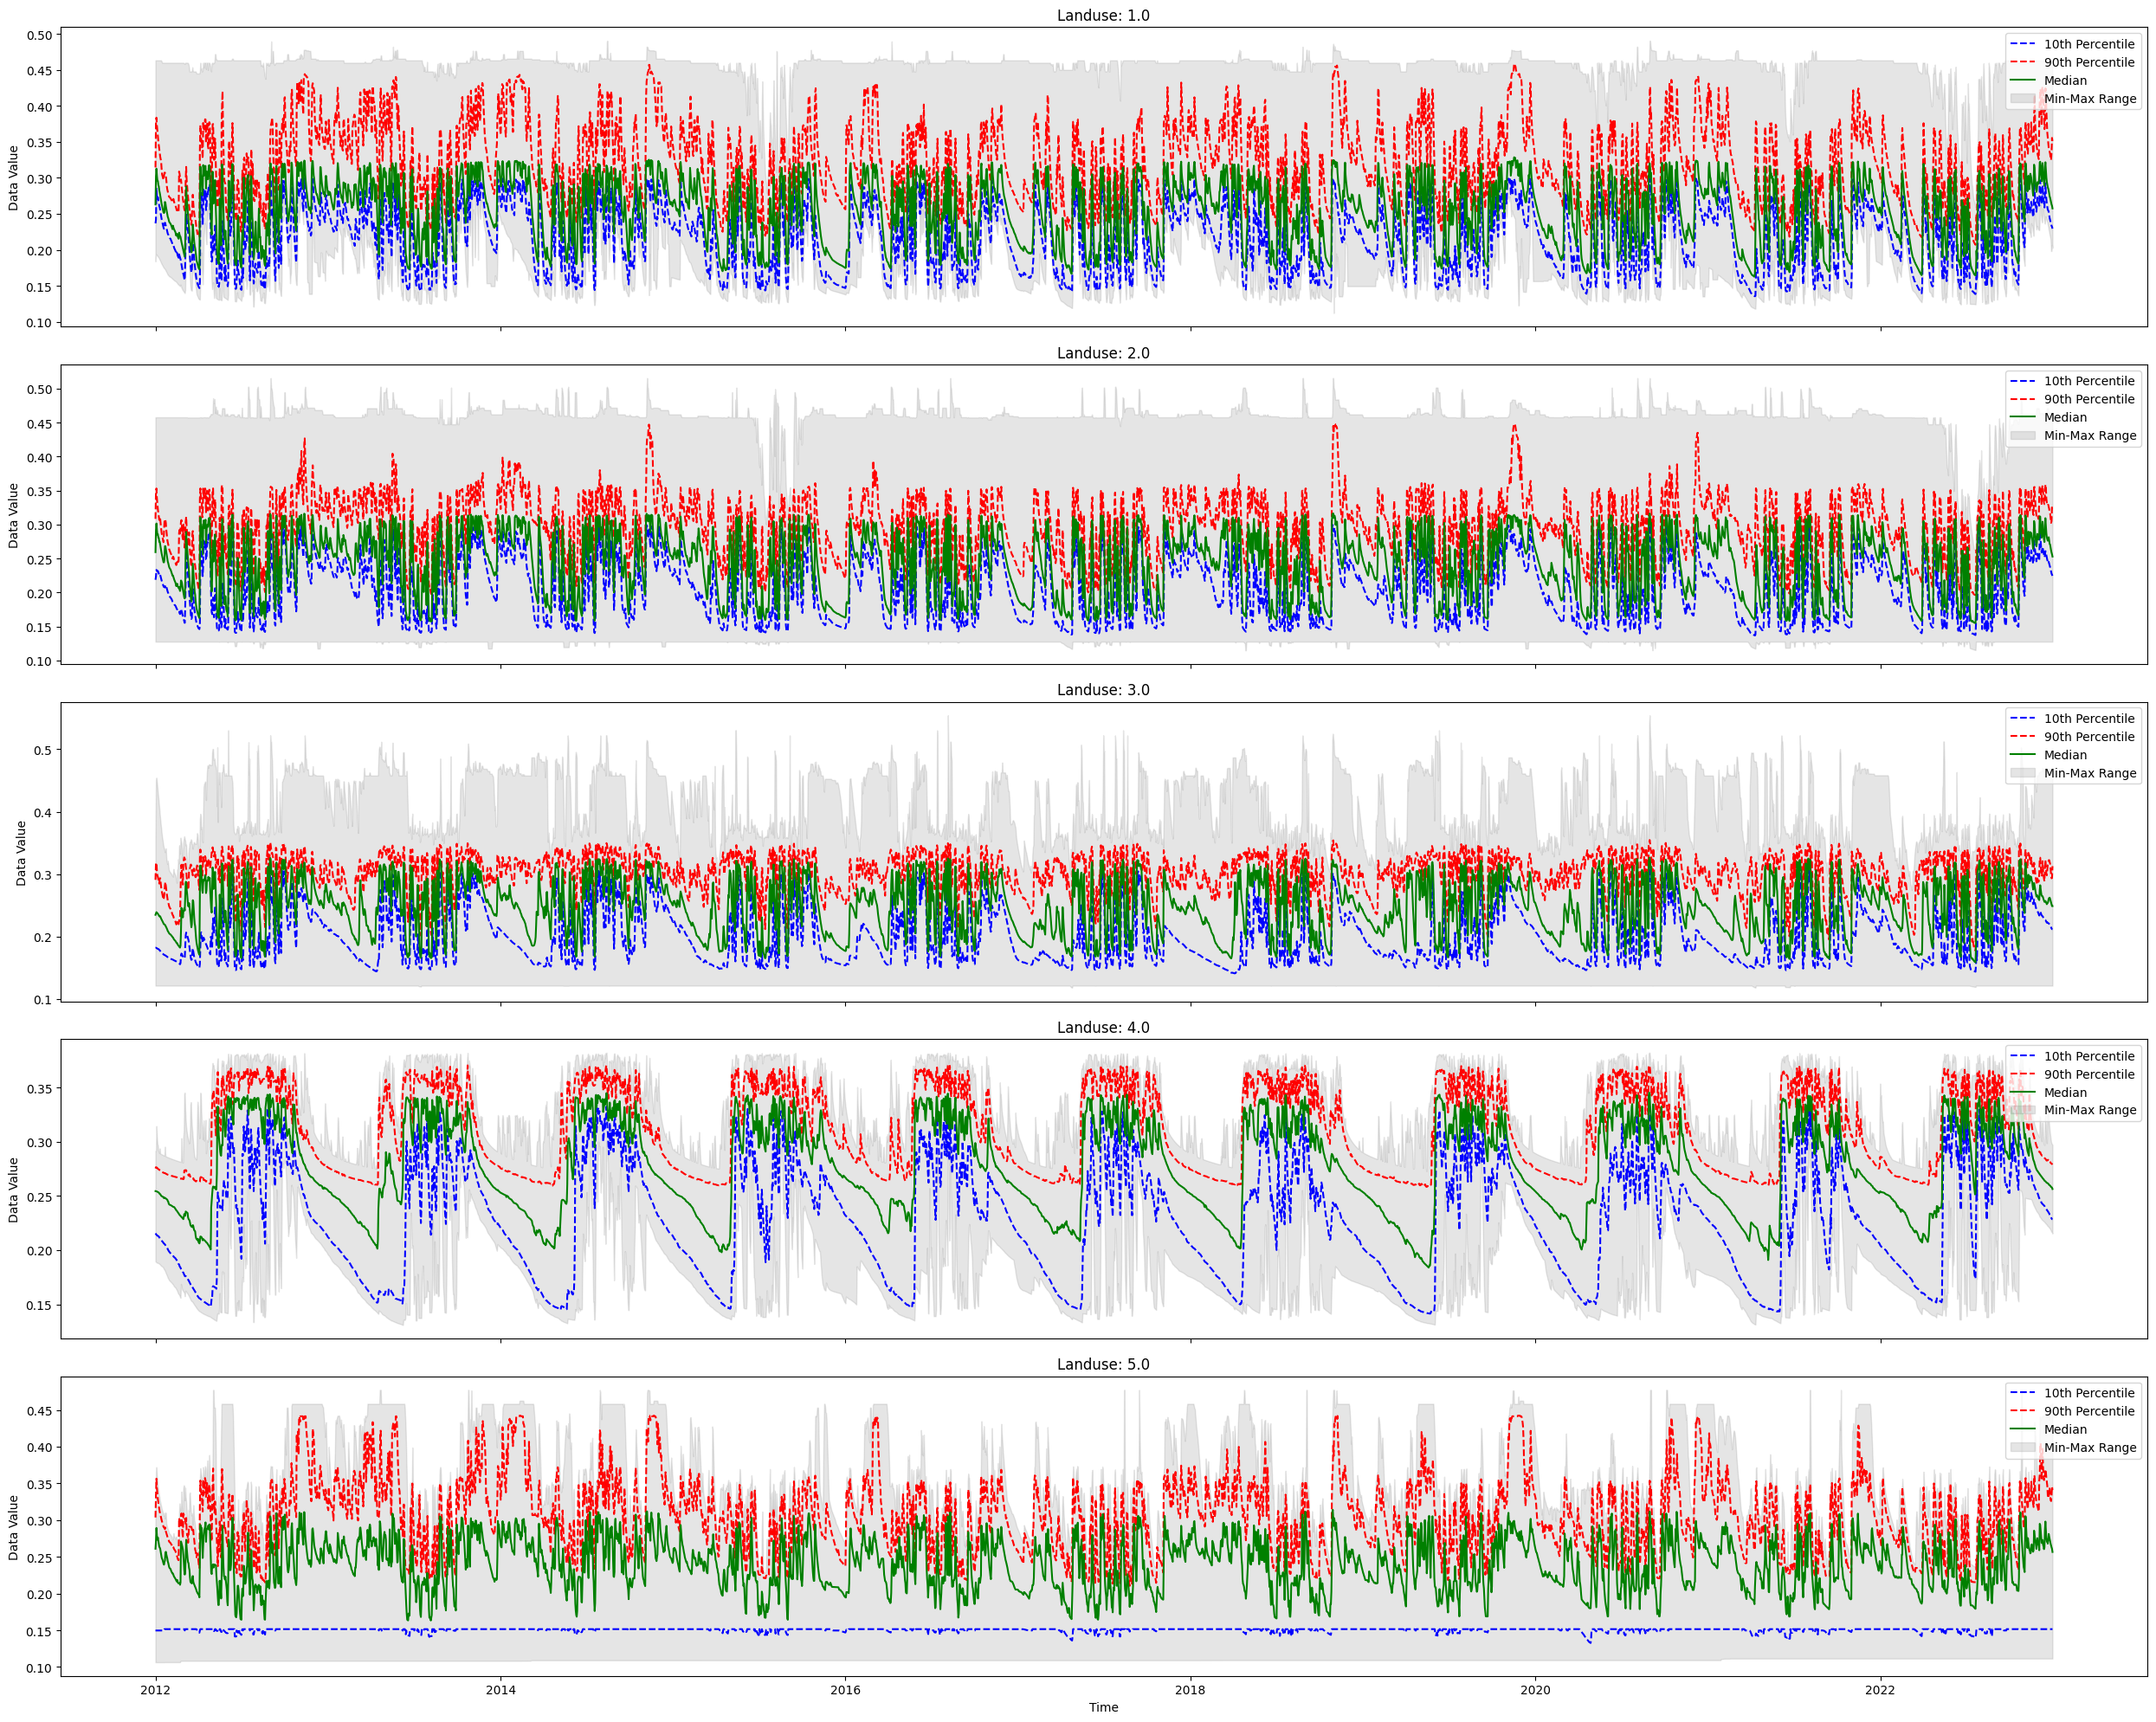

CPU times: user 9.72 s, sys: 3.05 s, total: 12.8 s
Wall time: 20.6 s


In [4]:
%time figure, axss = plot_spatio_temporal_data_cluster(dataset, categorized_data, method="summary", cluster_name="Landuse")

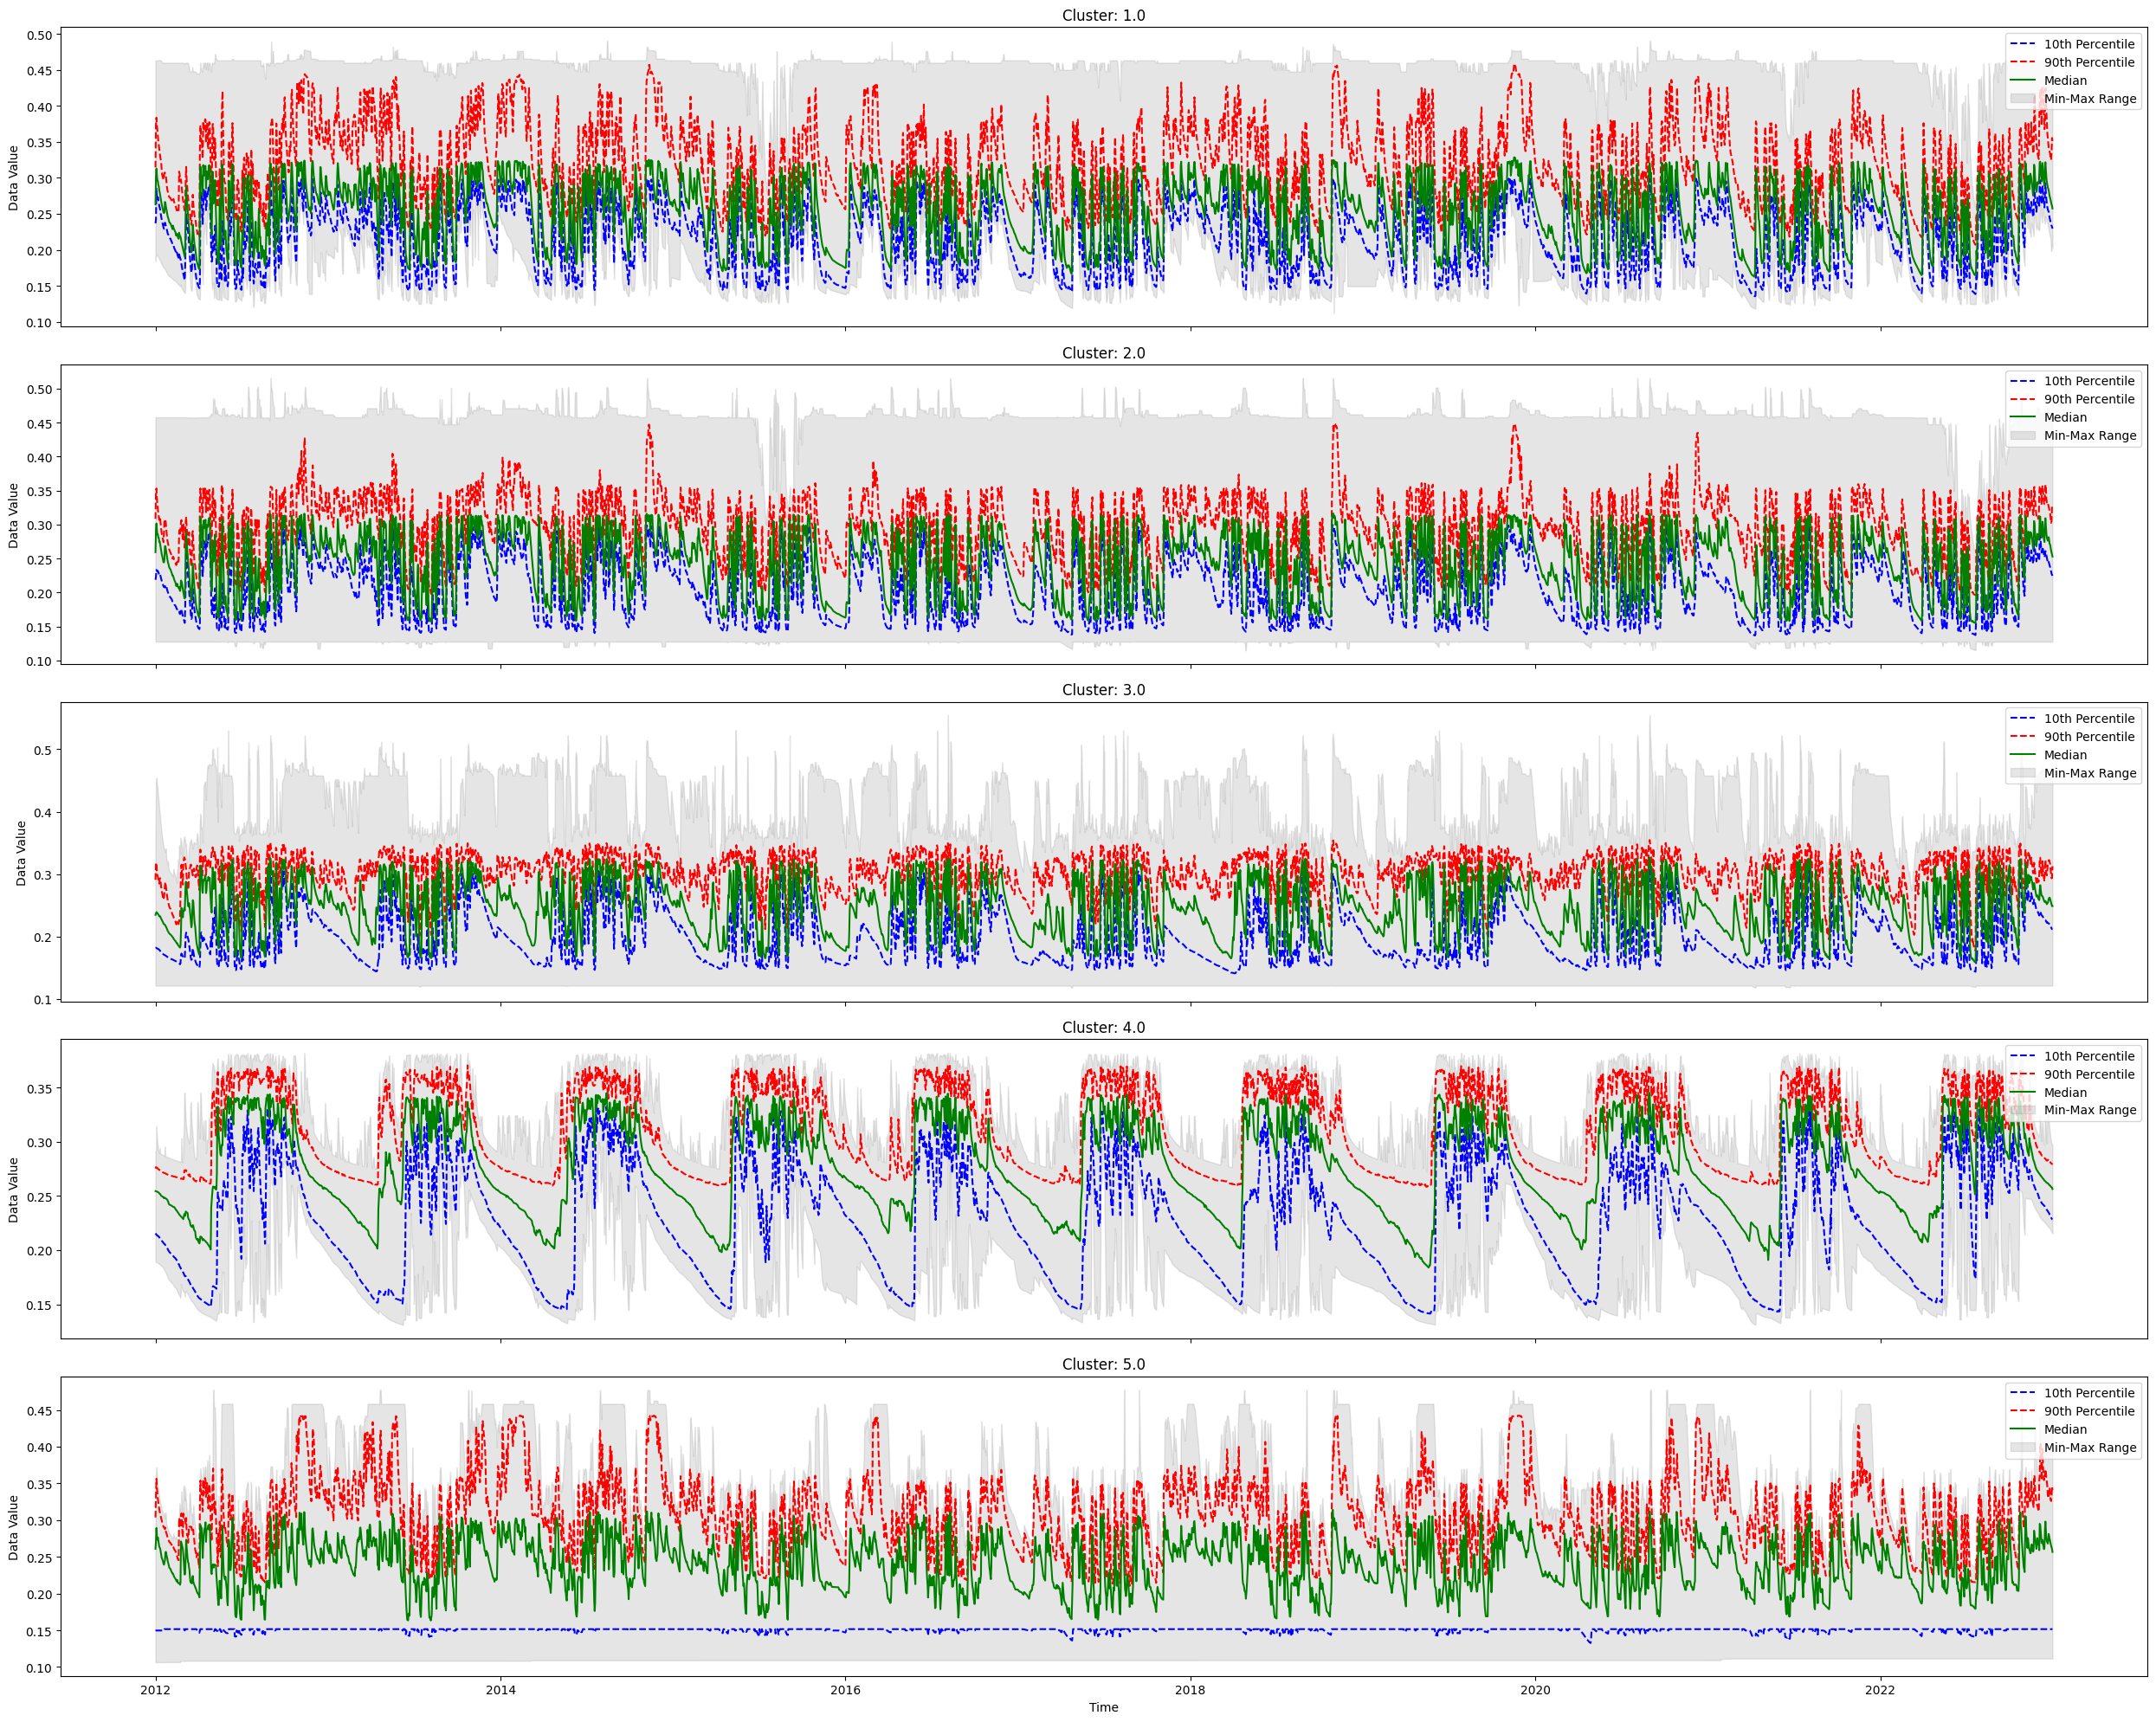

CPU times: user 10.3 s, sys: 2.81 s, total: 13.1 s
Wall time: 23.3 s


In [5]:
%time figure, axss = plot_spatio_temporal_data_cluster(dataset, categorized_data, method="summary")